In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
from yahooquery import Ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [5]:
# Read generated buys
trades = pd.read_csv('../output/trades.csv')
trades['just_date'] = pd.to_datetime(trades['just_date'])
business_days = [pd.Timestamp(date.astype(datetime)) for date in list(trades['just_date'].unique())]

In [6]:
trades.head()

,index,symbol,just_date,close_price_x,buy_signal?1,sell_signal?1,buy_signal?2,sell_signal?2,buy_signal?3,sell_signal?3,buy_signal?4,sell_signal?4,buy_signal?5,sell_signal?5
0,0,CLGX,2017-01-25,35.320000,None,None,None,None,None,None,None,None,None,None
1,1,CLGX,2017-01-26,35.189999,None,None,None,None,None,None,None,None,None,None
2,2,CLGX,2017-01-27,35.009998,None,None,None,None,None,None,None,None,None,None
3,3,CLGX,2017-01-30,35.279999,None,None,None,None,None,None,None,None,None,None
4,4,CLGX,2017-01-31,35.270000,None,None,None,None,None,None,None,None,None,None


### Import Earnings

In [7]:
# Read Earnings
earnings = pd.read_csv('../docs/earnings.csv')
earnings['earnings_date_90d'] = pd.to_datetime(earnings['earnings_date']) - timedelta(days=90)

# Merge with trades
trades = pd.merge(trades, earnings, how='left', left_on=['symbol', 'just_date'], right_on=['symbol', 'earnings_date_90d'])
trades['earnings_date'] = trades.groupby(['symbol']).ffill()['earnings_date']
trades['earnings_date'] = pd.to_datetime(trades['earnings_date'])
trades['earnings_difference'] = trades['just_date'] - trades['earnings_date']
trades['earnings_difference'] = trades['earnings_difference'].dt.days

# Add Previous day price column for Trailing Loss calculation
trades['previous_day_price'] = trades.groupby(['symbol']).shift(1)['close_price_x']

# Drop Columns
trades.drop(columns=['earnings_date_90d', 'earnings_date'], inplace=True)

### Create DataFrames of Buys and Sells
#### Buys

In [8]:
def extract_buys(df, pair_of_signals, buy_date, how_much, balances):
    
    # Create empty list to store results
    buys_list = []
    
    # Final balances
    final_balances = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for idx, item in enumerate(pair_of_signals):
        
        #Define buy and sell signals
        buy_signal = item[0]
        sell_signal = item[1]
        
        # Reset exclude symbols
        exclude_symbols = []
        
        # Initial balance
        current_balance = balances[idx]
        
        # Calculate how_much
        
        
        # Create dataframe with buys
        buys = df[(df['just_date'] == buy_date) 
                    & (df[buy_signal] == True)
                    & (df[sell_signal] != True)
                    & (~df['earnings_difference'].between(-5,-1))][['symbol', 'just_date', 'close_price_x']]
        
        # Check if there's enough money to buy
        for index, row in buys.iterrows():
            if current_balance >= how_much:
                current_balance = current_balance - how_much
            else:
                exclude_symbols.append(row['symbol'])
        
        # Remove excluded symbols
        if len(exclude_symbols) > 0:
            buys = buys[~buys['symbol'].isin(exclude_symbols)]
        
        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = how_much / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
        
        # Append current balance
        final_balances.append(current_balance)
        
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
            
        # Else then append buys
        else:
            buys.columns = columns_list
            [buys_list.append(i) for i in buys.values.tolist()]
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)

    return buys_df, final_balances

### Sells

In [9]:
def extract_sells(trades, date, sell_signal):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades[sell_signal] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [11]:
# Define Min, Max and Moving Dates
min_date = trades['just_date'].min()
max_date = trades['just_date'].max()
number_of_days = (max_date - min_date).days + 1
count = 1

# Result Lists
holdings_list = []
rgl_list = []

# The moving date gives sells/buys on a given day.
moving_date = min_date

# List of buy signals to be analyzed
pair_of_signals = [ ('buy_signal?1', 'sell_signal?1'),
                    ('buy_signal?2', 'sell_signal?2'),
                    ('buy_signal?3', 'sell_signal?3'),
                    ('buy_signal?4', 'sell_signal?4'),
                    ('buy_signal?5', 'sell_signal?5')]

# Balances
initial_balances = [5000 for i in range(len(pair_of_signals))]
list_of_balances = []

# How much to add every month
more_cash = [0 for i in range(len(pair_of_signals))]

# Max loss and holdings
max_loss = -0.10
max_holdings = 60

# Max Gain - Scalping
max_gain = 0.30

# calendar
calendar = []

# While moving date is less or equal to max_date
while moving_date <= max_date:
    
    # On the first day of the month we will add more 100 bucks
    if moving_date.day == 1:
        # Add cash every month
        current_balances = [x + y for x, y in zip(current_balances, more_cash)]
    
    # Add to calendar
    calendar.append(moving_date)
    
    # Start tracking time
    start_time = time.time()
    
    # If it's the first date, the process is different, because holdings and rgl need to be created yet
    if moving_date == min_date:
        
        # Figure out buys
        buys, current_balances = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=200, balances=initial_balances)
        
        # Create holdings
        holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # As of Date and close_price columns
        holdings_df['as_of_date'] = moving_date
        holdings_df['day_close_price'] = 0
        
        # Convert symbols to string to avoid merging problems in the future
        holdings_df['symbol'] = holdings_df['symbol'].astype(str)
        
        # Holdings append
        holdings_list.append(holdings_df.values.tolist())
        
        # Create RGL
        rgl_df = holdings_df.copy()
        rgl_list.append(rgl_df.values.tolist())
                
    # If it's not the first day:
    else:
        
        # Create prices dataframe from trades
        prices = trades[trades['just_date'] == moving_date][['symbol', 'close_price_x']]
        prices.columns = ['symbol', 'day_close_price']
        
        # Get Previous Day's Holdings and store the number of securities held on that day
        
        #previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
        previous_holdings = pd.DataFrame(holdings_list[-1])
        previous_holdings = previous_holdings.iloc[:,0:6]
        previous_holdings.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares',
                                       'cost_basis']
        #previous_holdings = previous_holdings.drop('day_close_price', axis=1)
        #previous_holdings.drop(['as_of_date'], axis=1, inplace=True)
        
        # Create Temporary RGL List to Append results from each strategy
        rgl_temp = []
        holdings_temp = []
        temp_balances = []
        
        # Loop through different strategies
        for idx, item in enumerate(pair_of_signals):
            
            #Signals
            buy_signal = item[0]
            sell_signal = item[1]
            
            # Reset value of sell
            money_from_sell = 0
            
            # Strategy Holdings
            strategy_holdings = previous_holdings[previous_holdings['strategy'] == buy_signal]
            
            # Check the number of Holdings symbols in a given strategy
            number_of_symbols = len(strategy_holdings['symbol'].unique())
        
            # Figure out sells and create list of symbols with sell signals
            sells = extract_sells(trades, moving_date, sell_signal=sell_signal)
            sold_symbols = set(sells['symbol'])
        
            # Remove sells from Previous Day's Holdings
            holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
        
            # Do the following with the securities that were left (only in business days)
            if moving_date in business_days:
                
                # Create new sell signals based on max_loss and max_holdings
                # Calculate % gain
                stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
                stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
                stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
            
                # Create column with date and remove 0's from sells
                stop_loss_sells['just_date'] = moving_date
                stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]
                
                # If sell signals were generated from this, then do the following
                if len(stop_loss_sells) > 0:
                
                    # Calculate the number of Holding Days, which is the difference between buy_date and just_date
                    stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - pd.to_datetime(stop_loss_sells['buy_date']))
                    stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days
                
                    # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                    stop_loss_sells = stop_loss_sells[
                        (stop_loss_sells['%_gain'] < max_loss)
                       |(stop_loss_sells['%_gain'] > max_gain)
                       |(stop_loss_sells['holding_days'] > max_holdings)][['symbol', 'just_date', 'day_close_price']]
                    
                    # Create order_type column and rename columns
                    stop_loss_sells['order_type'] = 'sell'
                    stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                    # Concatenate new sells with sells generated from sell_signal? 
                    sells = pd.concat([sells, stop_loss_sells]).drop_duplicates()

                    # Create list of sold symbols
                    sold_symbols = set(sells['symbol'])

                # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
                holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
                
            # Append results into holdings_temp
            [holdings_temp.append(i) for i in holdings_no_sells.values.tolist()]
        
            # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
            if len(sold_symbols) > 0:

                # Create Dataframe by merging Previous Day's Holdings with sells dataframe
                today_rgl = pd.merge(strategy_holdings, sells, how='inner', on='symbol')

                # Get prices in which the securities were sold
                today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')

                # Create as of date column and calculate gains and market value
                today_rgl['as_of_date'] = moving_date
                today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
                today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
                today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1

                # Add that into master rgl_df
                #rgl_df = pd.concat([rgl_df, today_rgl])
                if len(today_rgl) > 0:
                    rgl_temp.append(today_rgl.values.tolist())
                    money_from_sell = today_rgl[today_rgl['strategy'] == buy_signal].sum()['market_value']
            
            # Append results in temp_balance
            temp_balances.append(money_from_sell)        
        
        # New Current balance
        current_balances = [x + y for x, y in zip(current_balances, temp_balances)]
        
        # Append results into rgl_list
        [rgl_list.append(i) for i in rgl_temp]
        
        # Now that sold securities have been removed from holdings, it's time to look for buys
        buys, current_balances = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=100, balances=current_balances)
        buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # Add Buys to holdings
        columns = holdings_no_sells.columns
        holdings_data_frame = [i for i in holdings_temp]
        holdings_no_sells_temp = pd.DataFrame(holdings_data_frame, columns=columns)
        today = pd.concat([holdings_no_sells_temp, buys])
        today = today.drop_duplicates()
        today['as_of_date'] = moving_date
         
        # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
        number_of_symbols = len(today['symbol'].unique())
        
        # If you have more than one security (there's a placeholder, so we need more than one)
        # Then pull prices to calculate market value and % gain
        if number_of_symbols > 1:
            today = pd.merge(today, prices, on='symbol', how='left')
            today['market_value'] = today['shares'] * today['day_close_price']
            today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
        
        # Append with master holdings
        #holdings_df = holdings_df.append(today)
        holdings_list.append(today.values.tolist())
        
        # Create list with balances
        balance_day = current_balances
        balance_day.append(moving_date)
        list_of_balances.append(balance_day)
        
        # Completion %
        print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds')
    
    # Previous day becomes moving_date and moving date becomes moving date plus one day
    previous_day = moving_date
    moving_date += timedelta(days=1)
    count += 1

0.16 % - 0.1 seconds
0.25 % - 0.1 seconds
0.33 % - 0.1 seconds
0.41 % - 0.1 seconds
0.49 % - 0.1 seconds
0.58 % - 0.1 seconds
0.66 % - 0.1 seconds
0.74 % - 0.1 seconds
0.82 % - 0.1 seconds
0.91 % - 0.1 seconds
0.99 % - 0.1 seconds
1.07 % - 0.1 seconds
1.15 % - 0.1 seconds
1.24 % - 0.1 seconds
1.32 % - 0.1 seconds
1.4 % - 0.1 seconds
1.48 % - 0.1 seconds
1.57 % - 0.1 seconds
1.65 % - 0.2 seconds
1.73 % - 0.2 seconds
1.81 % - 0.1 seconds
1.9 % - 0.1 seconds
1.98 % - 0.1 seconds
2.06 % - 0.1 seconds
2.14 % - 0.1 seconds
2.23 % - 0.1 seconds
2.31 % - 0.1 seconds
2.39 % - 0.1 seconds
2.47 % - 0.2 seconds
2.56 % - 0.2 seconds
2.64 % - 0.1 seconds
2.72 % - 0.1 seconds
2.8 % - 0.2 seconds
2.89 % - 0.2 seconds
2.97 % - 0.2 seconds
3.05 % - 0.2 seconds
3.13 % - 0.2 seconds
3.22 % - 0.1 seconds
3.3 % - 0.1 seconds
3.38 % - 0.2 seconds
3.46 % - 0.2 seconds
3.54 % - 0.2 seconds
3.63 % - 0.2 seconds
3.71 % - 0.2 seconds
3.79 % - 0.1 seconds
3.87 % - 0.1 seconds
3.96 % - 0.2 seconds
4.04 % - 0.2 seco

31.57 % - 0.1 seconds
31.66 % - 0.2 seconds
31.74 % - 0.2 seconds
31.82 % - 0.2 seconds
31.9 % - 0.3 seconds
31.99 % - 0.2 seconds
32.07 % - 0.1 seconds
32.15 % - 0.1 seconds
32.23 % - 0.1 seconds
32.32 % - 0.2 seconds
32.4 % - 0.2 seconds
32.48 % - 0.2 seconds
32.56 % - 0.2 seconds
32.65 % - 0.1 seconds
32.73 % - 0.1 seconds
32.81 % - 0.2 seconds
32.89 % - 0.2 seconds
32.98 % - 0.2 seconds
33.06 % - 0.2 seconds
33.14 % - 0.3 seconds
33.22 % - 0.1 seconds
33.31 % - 0.1 seconds
33.39 % - 0.2 seconds
33.47 % - 0.2 seconds
33.55 % - 0.2 seconds
33.64 % - 0.3 seconds
33.72 % - 0.2 seconds
33.8 % - 0.1 seconds
33.88 % - 0.1 seconds
33.97 % - 0.2 seconds
34.05 % - 0.2 seconds
34.13 % - 0.2 seconds
34.21 % - 0.2 seconds
34.3 % - 0.2 seconds
34.38 % - 0.1 seconds
34.46 % - 0.1 seconds
34.54 % - 0.2 seconds
34.62 % - 0.2 seconds
34.71 % - 0.2 seconds
34.79 % - 0.3 seconds
34.87 % - 0.3 seconds
34.95 % - 0.1 seconds
35.04 % - 0.1 seconds
35.12 % - 0.3 seconds
35.2 % - 0.2 seconds
35.28 % - 0.3 s

62.49 % - 0.2 seconds
62.57 % - 0.2 seconds
62.65 % - 0.1 seconds
62.74 % - 0.1 seconds
62.82 % - 0.2 seconds
62.9 % - 0.2 seconds
62.98 % - 0.2 seconds
63.07 % - 0.2 seconds
63.15 % - 0.2 seconds
63.23 % - 0.1 seconds
63.31 % - 0.1 seconds
63.4 % - 0.2 seconds
63.48 % - 0.2 seconds
63.56 % - 0.2 seconds
63.64 % - 0.2 seconds
63.73 % - 0.2 seconds
63.81 % - 0.1 seconds
63.89 % - 0.1 seconds
63.97 % - 0.2 seconds
64.06 % - 0.2 seconds
64.14 % - 0.2 seconds
64.22 % - 0.3 seconds
64.3 % - 0.3 seconds
64.39 % - 0.1 seconds
64.47 % - 0.1 seconds
64.55 % - 0.2 seconds
64.63 % - 0.3 seconds
64.72 % - 0.2 seconds
64.8 % - 0.5 seconds
64.88 % - 0.3 seconds
64.96 % - 0.1 seconds
65.05 % - 0.1 seconds
65.13 % - 0.2 seconds
65.21 % - 0.2 seconds
65.29 % - 0.2 seconds
65.38 % - 0.2 seconds
65.46 % - 0.2 seconds
65.54 % - 0.1 seconds
65.62 % - 0.1 seconds
65.7 % - 0.3 seconds
65.79 % - 0.3 seconds
65.87 % - 0.3 seconds
65.95 % - 0.2 seconds
66.03 % - 0.2 seconds
66.12 % - 0.1 seconds
66.2 % - 0.1 se

93.4 % - 0.2 seconds
93.49 % - 0.2 seconds
93.57 % - 0.2 seconds
93.65 % - 0.2 seconds
93.73 % - 0.2 seconds
93.82 % - 0.1 seconds
93.9 % - 0.1 seconds
93.98 % - 0.2 seconds
94.06 % - 0.2 seconds
94.15 % - 0.2 seconds
94.23 % - 0.2 seconds
94.31 % - 0.2 seconds
94.39 % - 0.1 seconds
94.48 % - 0.1 seconds
94.56 % - 0.2 seconds
94.64 % - 0.2 seconds
94.72 % - 0.2 seconds
94.81 % - 0.2 seconds
94.89 % - 0.2 seconds
94.97 % - 0.1 seconds
95.05 % - 0.1 seconds
95.14 % - 0.2 seconds
95.22 % - 0.2 seconds
95.3 % - 0.2 seconds
95.38 % - 0.3 seconds
95.47 % - 0.2 seconds
95.55 % - 0.1 seconds
95.63 % - 0.1 seconds
95.71 % - 0.3 seconds
95.8 % - 0.2 seconds
95.88 % - 0.2 seconds
95.96 % - 0.2 seconds
96.04 % - 0.2 seconds
96.13 % - 0.1 seconds
96.21 % - 0.1 seconds
96.29 % - 0.2 seconds
96.37 % - 0.2 seconds
96.46 % - 0.2 seconds
96.54 % - 0.2 seconds
96.62 % - 0.1 seconds
96.7 % - 0.1 seconds
96.78 % - 0.1 seconds
96.87 % - 0.2 seconds
96.95 % - 0.3 seconds
97.03 % - 0.2 seconds
97.11 % - 0.2 s

## Daily Holdings

In [17]:
data_frame_list = [x for b in holdings_list for x in b]
holdings_df = pd.DataFrame(data_frame_list)
holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date', 'day_close_price', 'market_value', '%_gain']
holdings_df['$_gain'] = holdings_df['market_value'] - holdings_df['cost_basis']
holdings_df[holdings_df['symbol'] == 'VIVO'].tail()


,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,market_value,%_gain,$_gain
169966,buy_signal?5,2020-05-11 00:00:00,VIVO,18.120001,5.518764,100.0,2020-05-13,17.320000,95.584983,-0.044150,-4.415017
170030,buy_signal?5,2020-05-11 00:00:00,VIVO,18.120001,5.518764,100.0,2020-05-14,16.600000,91.611477,-0.083885,-8.388523
170086,buy_signal?5,2020-05-11 00:00:00,VIVO,18.120001,5.518764,100.0,2020-05-15,16.440001,90.728476,-0.092715,-9.271524
170144,buy_signal?5,2020-05-11 00:00:00,VIVO,18.120001,5.518764,100.0,2020-05-16,NaN,NaN,NaN,NaN
170201,buy_signal?5,2020-05-11 00:00:00,VIVO,18.120001,5.518764,100.0,2020-05-17,NaN,NaN,NaN,NaN


## Daily Balances

In [18]:
# Create list to store rows with balances
balances_to_df = []

# Go through list of balances
for row in list_of_balances:
    # Extract date from row
    date = row[-1]
    # for each pair of signals append balance
    [balances_to_df.append([signal_pair[0], row[idx], date]) for idx, signal_pair in enumerate(pair_of_signals)]
    
# Create dataframe
balances_df = pd.DataFrame(balances_to_df, columns = ['strategy', 'market_value', 'as_of_date'])
balances_df['symbol'] = 'CASH'
balances_df = balances_df.set_index('as_of_date')

In [19]:
balances_df.head()

,strategy,market_value,symbol
as_of_date,,,
2017-01-26,buy_signal?1,5000.0,CASH
2017-01-26,buy_signal?2,5000.0,CASH
2017-01-26,buy_signal?3,5000.0,CASH
2017-01-26,buy_signal?4,5000.0,CASH
2017-01-26,buy_signal?5,5000.0,CASH


## Daily RGL

In [20]:
data_frame_list_rgl = [x for b in rgl_list for x in b]
rgl_df = pd.DataFrame(data_frame_list_rgl)
rgl_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date',
                  'day_close_price', 'order_type', 'price', 'sell_date', 'market_value', '$_gain', '%_gain']
rgl_df.head()

,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,order_type,price,sell_date,market_value,$_gain,%_gain
0,buy_signal?1,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,NaT,NaN,NaN,NaN
1,buy_signal?2,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,NaT,NaN,NaN,NaN
2,buy_signal?3,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,NaT,NaN,NaN,NaN
3,buy_signal?4,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,NaT,NaN,NaN,NaN
4,buy_signal?5,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,NaT,NaN,NaN,NaN


In [21]:
# Set Index to date
calendar_df = holdings_df[['as_of_date']].drop_duplicates()
calendar_df.columns = ['date']
holdings_df = holdings_df.set_index('as_of_date')
rgl_df = pd.merge(calendar_df, rgl_df, left_on='date', right_on='sell_date', how='left' )
rgl_df = rgl_df.set_index('date')

## Comparing different signals
### RGLs

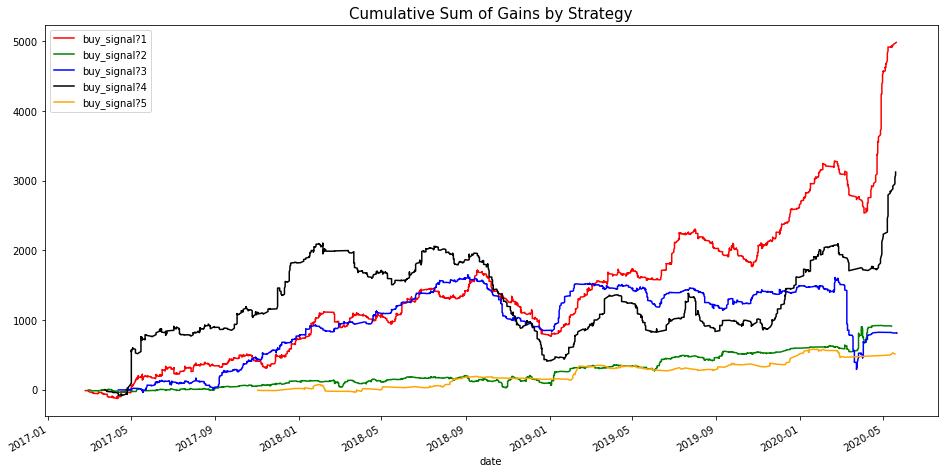

In [22]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    rgl_df[rgl_df['strategy'] == signal[0]]['$_gain'].cumsum().plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

## Sum of Non Realized Gains

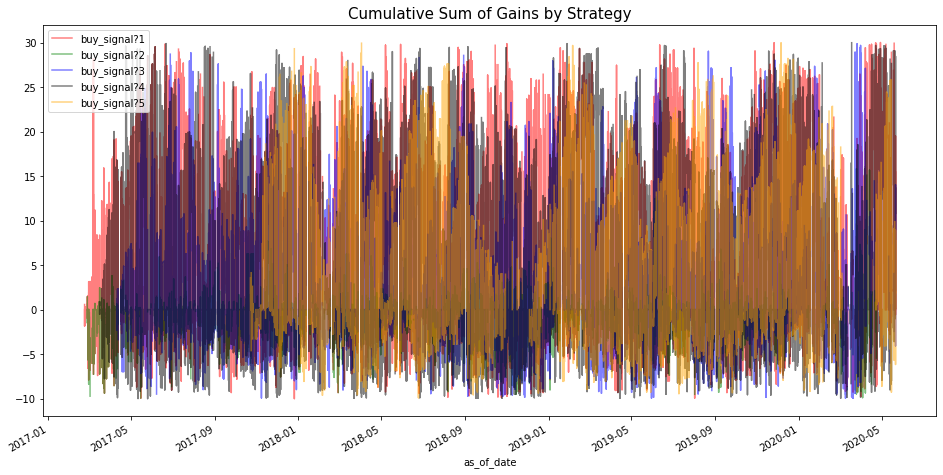

In [23]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]]['$_gain'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings - Cash not Included

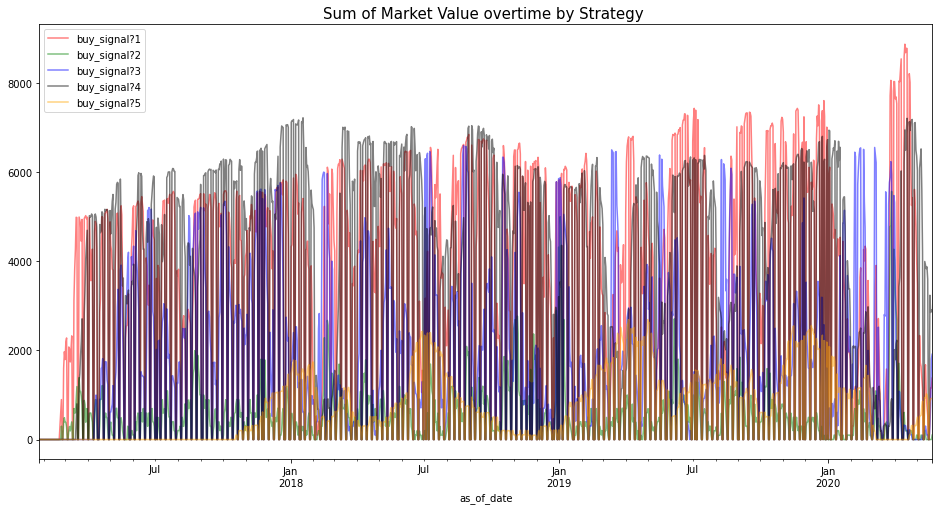

In [24]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


## Cash Balance overtime

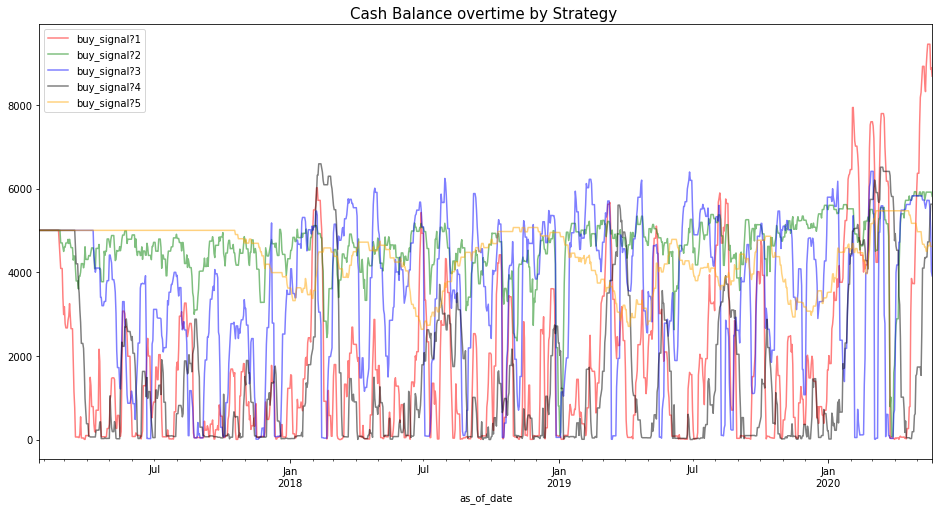

In [25]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cash Balance overtime by Strategy ', size=15);


## Holdings + Cash

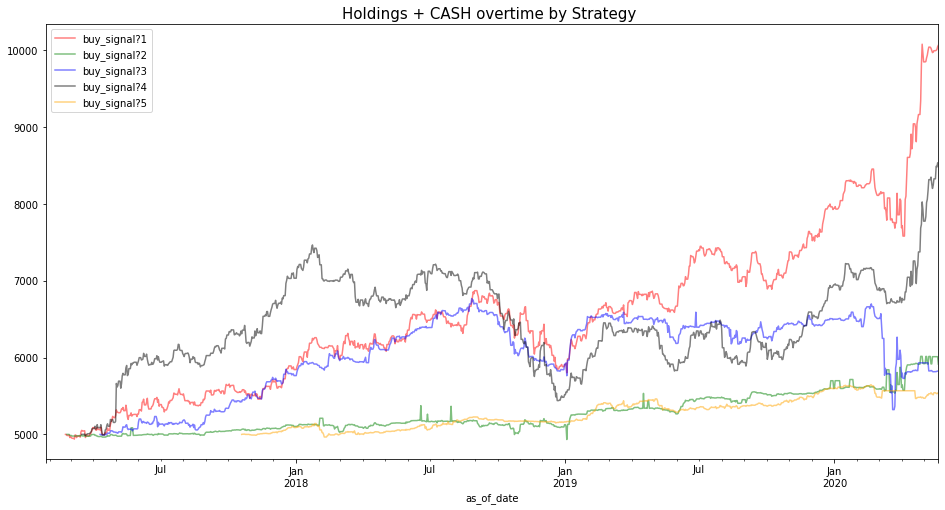

In [26]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    a = balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b = holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b.replace(0, np.NaN, inplace=True)
    a.columns = ['as_of_date', 'cash_balance']
    plot_me = pd.merge(a,b,how='left', on='as_of_date')
    plot_me['market_value'] = plot_me['market_value'].ffill()
    plot_me.set_index('as_of_date', inplace=True)
    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
    plot_me['total'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5, linestyle = '-')

plt.legend()
plt.title('Holdings + CASH overtime by Strategy ', size=15);


## Invested Money overtime

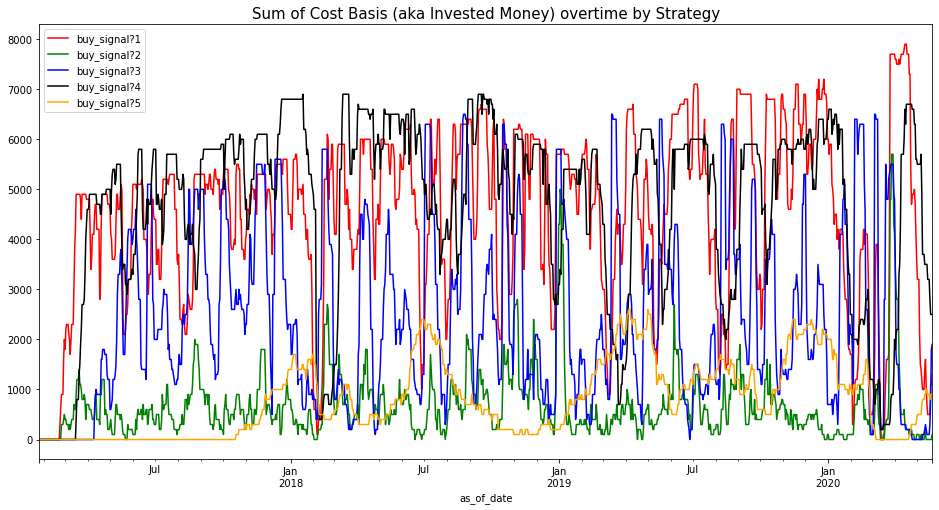

In [27]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);

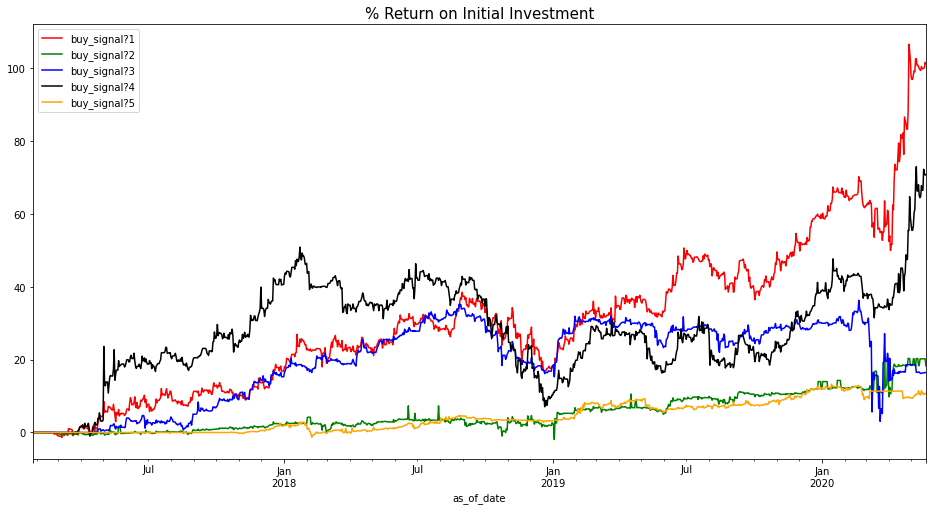

In [34]:
colors = ['red', 'green', 'blue', 'black', 'orange']

for idx, signal in enumerate(pair_of_signals):
    # Calulate gains, current_holdings and balances
    gains = rgl_df[rgl_df['strategy'] == signal[0]].fillna(0).groupby(level=0).sum()['$_gain'].reset_index()
    current_holdings = holdings_df[(holdings_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index().replace(0, np.NaN)
    current_balance = balances_df[(balances_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index()
    
    # Rename columns for balances
    current_balance.columns = ['as_of_date', 'cash_balance']
    
    # Forward Fill
    current_holdings['market_value'] = current_holdings['market_value'].ffill()
    
    # Create data_frame to plot
    to_plot = pd.merge(current_balance, current_holdings, how='left', on='as_of_date')
    to_plot = pd.merge(to_plot, gains, how='left', left_on='as_of_date', right_on='date')
    
    # calculate total
    to_plot.fillna(0, inplace=True)
    to_plot['%_return'] = 100*(((to_plot['$_gain'] + to_plot['market_value'] + to_plot['cash_balance']) / 5000) - 1)
    to_plot.set_index('as_of_date', inplace=True)
    
    to_plot['%_return'].plot(figsize=(16,8), color=colors[idx], label=signal[0])
    
plt.legend()
plt.title('% Return on Initial Investment', size=15);
    

# Export

In [246]:
rgl_df.reset_index().to_feather('../output/rgl.feather')

In [201]:
rgl_df[rgl_df['strategy'] == 'buy_signal?4']['market_value']

date
2017-04-13     88.484721
2017-04-17     93.293210
2017-04-26     97.090782
2017-04-26     98.279231
2017-04-26    102.744813
2017-04-26     99.354382
2017-04-26    128.571421
2017-04-28     90.592332
2017-04-28     89.041094
2017-04-28     91.228070
2017-04-28     84.017493
2017-04-28     93.965699
2017-04-28     92.100470
2017-04-28     92.909690
2017-05-01     96.502443
2017-05-01    103.662596
2017-05-01    105.393743
2017-05-03     73.761226
2017-05-08     90.806758
2017-05-08     93.436299
2017-05-08     93.256264
2017-05-08     94.163430
2017-05-17     86.904761
2017-05-18     96.054803
2017-05-19     89.882355
2017-05-19     90.736347
2017-05-19     91.223882
2017-05-19     96.020763
2017-05-22     93.340385
2017-05-23    139.682538
2017-05-25    117.161289
2017-05-31     86.366515
2017-06-05     89.142854
2017-06-06    101.818177
2017-06-06    100.298503
2017-06-09    135.287353
2017-06-12    100.152617
2017-06-12    100.574711
2017-06-12    100.000000
2017-06-14    102.12